# Practical Example

## Low dimension

The practical example consists of the stable space estimation for a multivariate time series that contains the information for several economic indicators associated with the inflation in Mexico on the period from 

In [43]:
# packages
remove(list = ls())
options(warn = -1)
suppressMessages(library(data.table))
suppressMessages(library(magrittr))
suppressMessages(library(ggplot2))
suppressMessages(library(xtable))
suppressMessages(library(GGally))

source("../source/simulations.R")
source("../source/vectorial_methods.R")
source("../source/auxiliar_methods.R")

## Economic variables associated with the inflation in Mexico

In [44]:
# Variables Inflation
dt_inflation <- data.table::fread("../databases/variables_inflation.csv")

Variables description:

- P: National Consumer Price Index
- U: Unemployment Rate
- BYM: Banknotes and Coins
- E: Nominal Exchange Rate
- R: 28-Day Interbank Interest Rate
- W: Real Wages
- PUSA: United States National Consumer Price Index 

First, we analise the covariance structure

In [45]:
options(repr.plot.width = 6, repr.plot.height =6)

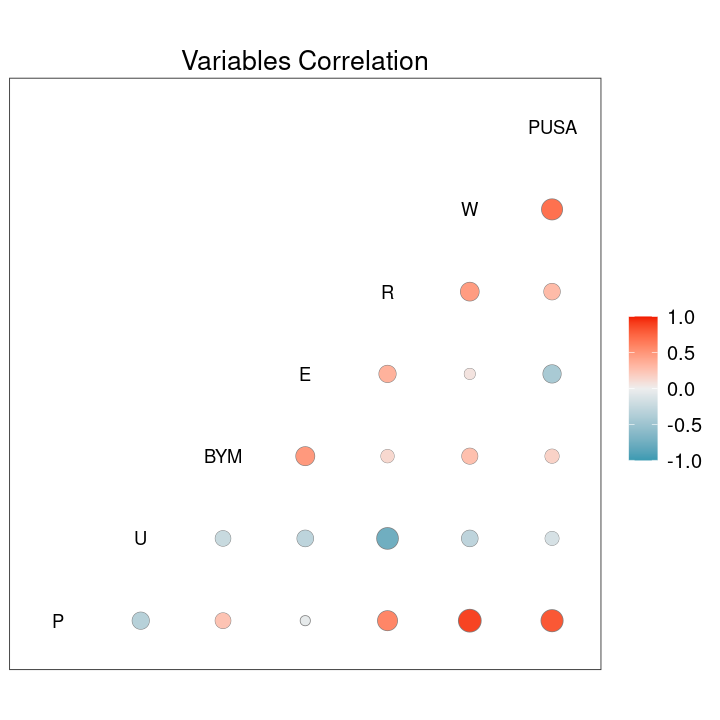

In [46]:
GGally::ggcorr(dt_inflation[,-c(1)],geom = "circle")+ggplot2::ggtitle("Variables Correlation")+mytheme

We centered the columns of the series, and we get the auxiliary blocks for the methods

In [47]:
X_inflation <- as.matrix(dt_inflation, rownames = "Date")
rownames(X_inflation) <- NULL
X_inflation <- scale(ts(X_inflation))
XX_inflation <- X_inflation[1:(nrow(X_inflation)-1),]
Y_inflation <- X_inflation[2:nrow(X_inflation),]

We check the order of integration of each variable and print the KPSS' p-value taking difference operator

In [48]:
aux <- X_inflation
I0_variables <- apply(aux,2,function(x) tseries::kpss.test(x)$p.value)
I1_variables <- apply(diff(aux),2,function(x) tseries::kpss.test(x)$p.value)
I2_variables <- apply(diff(diff(aux)),2,function(x) tseries::kpss.test(x)$p.value)

# Example list with named vectors
list <- list(X = I0_variables, DX = I1_variables,
             DDX = I2_variables)

# Convert to data frame with row names
mat_order <- do.call(cbind, list)
print(xtable(mat_order,digits = 2))

% latex table generated in R 4.1.2 by xtable 1.8-4 package
% Tue Jun 24 22:25:41 2025
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & X & DX & DDX \\ 
  \hline
P & 0.01 & 0.01 & 0.10 \\ 
  U & 0.02 & 0.10 & 0.10 \\ 
  BYM & 0.10 & 0.10 & 0.10 \\ 
  E & 0.09 & 0.10 & 0.10 \\ 
  R & 0.02 & 0.04 & 0.10 \\ 
  W & 0.01 & 0.01 & 0.10 \\ 
  PUSA & 0.06 & 0.02 & 0.10 \\ 
   \hline
\end{tabular}
\end{table}


We estimate the stable space for this multivariate time series using the methods
- Johansen
- PCA
- PLS

In [49]:
basis_inflation_PLS <- basis_stable(X_inflation, method = "pls")
basis_inflation_PCA <- basis_stable(XX_inflation,method="pca")
basis_inflation_johansen <- basis_stable(XX_inflation,method = "johansen")

We visualise the weights for each methodology

In [50]:
options(repr.plot.width = 9, repr.plot.height = 6)

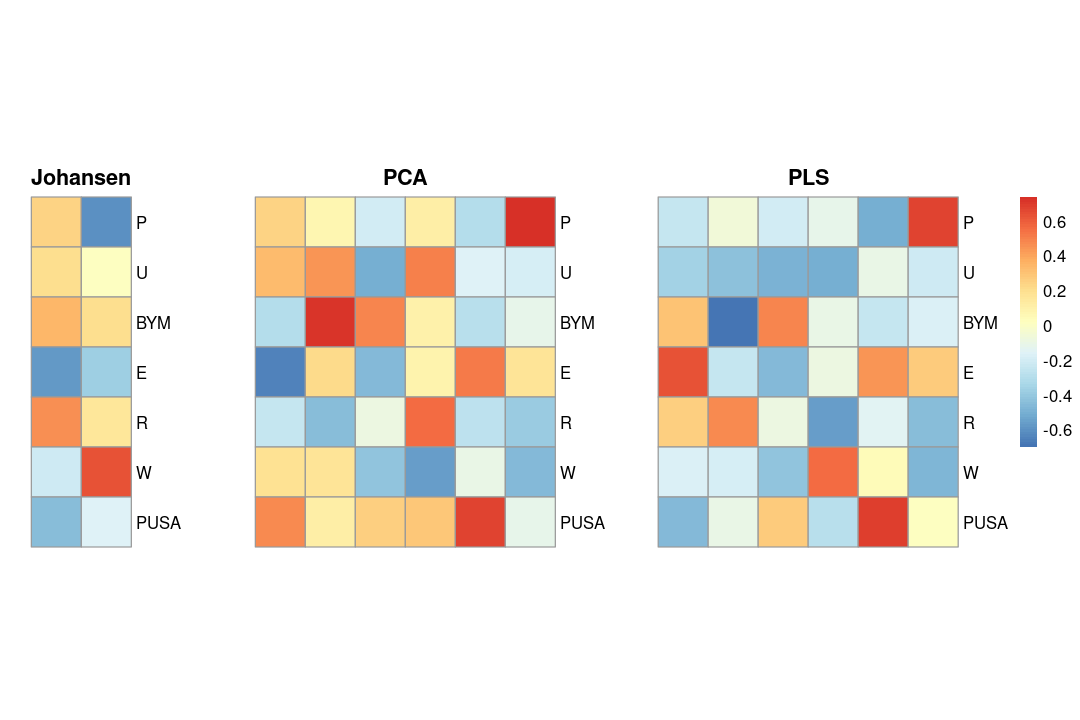

In [51]:
# Tables
table_inflation_PLS <- as.matrix(basis_inflation_PLS$weights_S)
table_inflation_PCA <- as.matrix(basis_inflation_PCA$basis_S)
table_inflation_johansen <- as.matrix(basis_inflation_johansen$basis_S)
rownames(table_inflation_PLS) <- colnames(X_inflation)
rownames(table_inflation_PCA) <- colnames(X_inflation)
rownames(table_inflation_johansen) <- colnames(X_inflation)

# Compute a common color scale range
min_value <- min(table_inflation_PLS, table_inflation_PCA, table_inflation_johansen)
max_value <- max(table_inflation_PLS, table_inflation_PCA, table_inflation_johansen)

# Define color palette
color_palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(9, "RdYlBu")))(100)

# Generate heatmaps with common limits
gg_map_PLS <- pheatmap::pheatmap(table_inflation_PLS, cluster_rows = FALSE, cluster_cols = FALSE,
    cellwidth = 30, cellheight = 30, silent = TRUE, main = "PLS", color = color_palette,
    breaks = seq(min_value, max_value, length.out = 101))

gg_map_PCA <- pheatmap::pheatmap(table_inflation_PCA, cluster_rows = FALSE, cluster_cols = FALSE,
    cellwidth = 30, cellheight = 30, silent = TRUE, main = "PCA", color = color_palette,
    breaks = seq(min_value, max_value, length.out = 101), legend = FALSE)

gg_map_johansen <- pheatmap::pheatmap(table_inflation_johansen, cluster_rows = FALSE, 
    cluster_cols = FALSE, cellwidth = 30, cellheight = 30, silent = TRUE, main = "Johansen", 
    color = color_palette, breaks = seq(min_value, max_value, length.out = 101),legend = FALSE)

# Combine plots
cowplot::plot_grid(gg_map_johansen[[4]], gg_map_PCA[[4]], gg_map_PLS[[4]], 
    nrow = 1, rel_widths = c(0.25, 0.5, 0.5))


## Projection Error

We quantify the projection error to the estimated stable space considering the first two stationary scores

In [52]:
# PLS
T_scores_PLS <- basis_inflation_PLS$stable_scores 
Y_est_PLS <- scores_rebuilt(T_scores_PLS[,1:2],Y=Y_inflation,method = "PLS")

# PCA
T_scores_PCA <- XX_inflation%*%basis_inflation_PCA$basis_S
Y_est_PCA <- scores_rebuilt(T_scores_PCA[,1:2],Y=Y_inflation)

# PCA with the first two components
T_scores_PCA_classic <- XX_inflation%*%cbind(basis_inflation_PCA$basis_N[,1],basis_inflation_PCA$basis_S[,1])
Y_est_PCA_classic <- scores_rebuilt(T_scores_PCA_classic[,1:2],Y=Y_inflation)

# Johansen
T_scores_johansen <- XX_inflation%*%basis_inflation_johansen$basis_S
Y_est_johansen <- scores_rebuilt(T_scores_johansen[,1], Y = Y_inflation)

Similarly, we could visualise the error or the time series studied

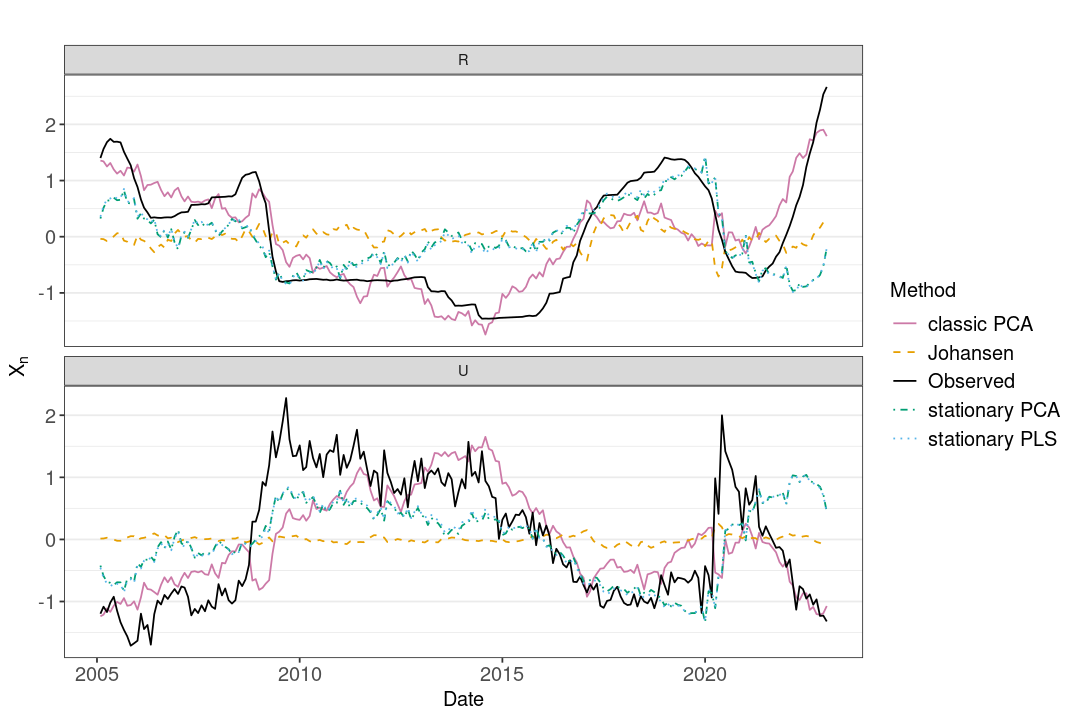

In [53]:
dates <- dt_inflation[,Date][2:nrow(dt_inflation)]
custom_linetypes <- c(
  "Observed" = "solid",
  "classic PCA" = "solid",
  "Johansen" = "dashed",
  "stationary PCA" = "dotdash",
  "stationary PLS" = "dotted")

custom_palette <- c(
  "Johansen" = "#E69F00",
  "stationary PLS" = "#56B4E9", 
  "stationary PCA" = "#009E73",
  "Observed" = "black",
  "classic PCA" = "#CC79A7")

plot_estimates_comparison(
  Y_obs = Y_inflation,
  Y_est_list = list(`stationary PLS` = Y_est_PLS$est, `stationary PCA` = Y_est_PCA$est, Johansen = Y_est_johansen$est, `classic PCA` = Y_est_PCA_classic$est),
  col_names = c("U", "R"),
  labels = c("stationary PLS", "stationary PCA", "Johansen","classic PCA"),  # optional if list has names
  dates = dates,
  method_palette = custom_palette, 
  method_linetypes = custom_linetypes
)

The numerical summary of the projection error is

In [54]:
MSE <- matrix(0,ncol(Y_inflation),4) 
colnames(MSE) <- c("Johansen","classic PCA","stationary PCA", "stationary PLS") ; rownames(MSE) <- colnames(Y_inflation)

# error estimation
MSE[,"stationary PLS"] <- VNMSE_(Y_inflation,Y_est_PLS$est)
MSE[,"stationary PCA"] <- VNMSE_(Y_inflation,Y_est_PCA$est)
MSE[,"classic PCA"] <- VNMSE_(Y_inflation,Y_est_PCA_classic$est)
MSE[,"Johansen"] <- VNMSE_(Y_inflation,Y_est_johansen$est)

We print the results for the article

In [55]:
print(xtable(MSE,digits = 2))

% latex table generated in R 4.1.2 by xtable 1.8-4 package
% Tue Jun 24 22:25:41 2025
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & Johansen & classic PCA & stationary PCA & stationary PLS \\ 
  \hline
P & 0.99 & 0.07 & 0.88 & 0.90 \\ 
  U & 0.99 & 0.44 & 0.65 & 0.63 \\ 
  BYM & 0.98 & 0.67 & 0.36 & 0.35 \\ 
  E & 0.84 & 0.24 & 0.25 & 0.24 \\ 
  R & 0.97 & 0.28 & 0.70 & 0.68 \\ 
  W & 0.90 & 0.22 & 0.90 & 0.92 \\ 
  PUSA & 1.00 & 0.11 & 0.56 & 0.60 \\ 
   \hline
\end{tabular}
\end{table}


As an extra, visualisation of the observed time series

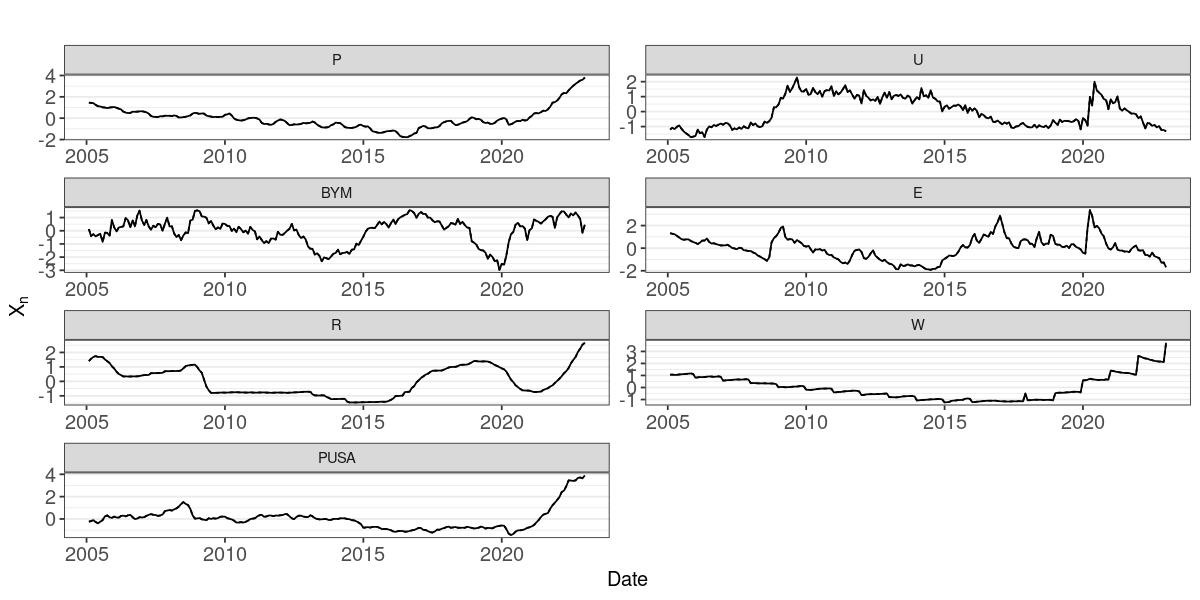

In [56]:
options(repr.plot.width = 10, repr.plot.height = 5) # plots width and heigth
dates <- dt_inflation[,Date][2:nrow(dt_inflation)]
vis2series(Y_inflation,Y_inflation,dates=dates,lab_X = "obs",lab_Y = "est",
            legend.position = "none",ncol=2)